In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.ndimage import gaussian_filter
from scipy.signal import butter, filtfilt

from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

In [3]:
file = 'Zzzs_train.parquet'
pandas_df = pd.read_parquet(file)

In [4]:
pandas_df.head()

,series_id,step,timestamp,anglez,enmo,awake
0,08db4255286f,0,2018-11-05T10:00:00-0400,-30.845301,0.0447,1
1,08db4255286f,1,2018-11-05T10:00:05-0400,-34.181801,0.0443,1
2,08db4255286f,2,2018-11-05T10:00:10-0400,-33.877102,0.0483,1
3,08db4255286f,3,2018-11-05T10:00:15-0400,-34.282101,0.0680,1
4,08db4255286f,4,2018-11-05T10:00:20-0400,-34.385799,0.0768,1


In [5]:
unique_series = pandas_df['series_id'].unique()

print(len(unique_series))

35


# Looking at one individual  

In [6]:
# the individual in question
person_id = unique_series[3]

one_person = pandas_df[pandas_df['series_id'] == person_id].copy()

one_person['date'] = pd.to_datetime(one_person['timestamp'], utc=True)
one_person['day'] = one_person['date'].dt.dayofweek
one_person['month'] = one_person['date'].dt.month
one_person['hour'] = one_person['date'].dt.hour

one_person['norm_anglez'] = one_person['anglez'].sub(one_person['anglez'].min()) / \
                            (one_person['anglez'].max() - one_person['anglez'].min())
                             
one_person['norm_enmo'] = one_person['enmo'].sub(one_person['enmo'].min()) / \
                          (one_person['enmo'].max() - one_person['enmo'].min())

one_person['awake_asleep_count'] = one_person['awake'].ne(one_person['awake'].shift()).cumsum()

one_person.drop(columns=['timestamp'], inplace=True)
one_person.set_index('date', inplace=True)

In [7]:
one_person.head()

,series_id,step,anglez,enmo,awake,day,month,hour,norm_anglez,norm_enmo,awake_asleep_count
date,,,,,,,,,,,
2018-03-13 18:15:00+00:00,1087d7b0ff2e,0,-87.805298,0.0227,1,1,3,18,0.012214,0.006320,1
2018-03-13 18:15:05+00:00,1087d7b0ff2e,1,-87.803802,0.0224,1,1,3,18,0.012222,0.006237,1
2018-03-13 18:15:10+00:00,1087d7b0ff2e,2,-87.798897,0.0225,1,1,3,18,0.012249,0.006265,1
2018-03-13 18:15:15+00:00,1087d7b0ff2e,3,-87.804802,0.0232,1,1,3,18,0.012216,0.006460,1
2018-03-13 18:15:20+00:00,1087d7b0ff2e,4,-87.799896,0.0232,1,1,3,18,0.012244,0.006460,1


In [8]:
# getting min and max date and calculating the total days
min_date = one_person.index.min()
max_date = one_person.index.max()

print("length of measurement period:", pd.Timedelta(max_date - min_date))

length of measurement period: 23 days 18:44:55


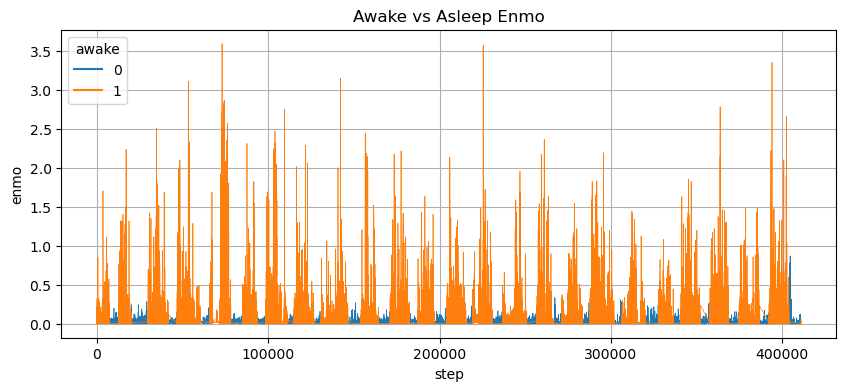

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(data=one_person, x="step", y="enmo",hue="awake", linewidth = 0.5)

plt.title("Awake vs Asleep Enmo")
plt.grid(True)
plt.show()

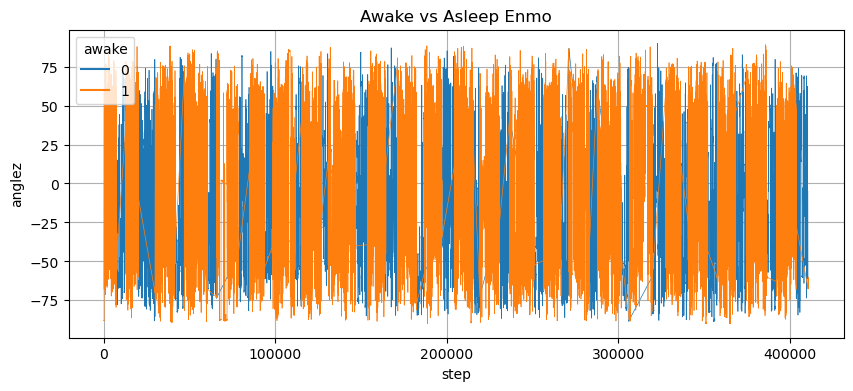

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(data=one_person, x="step", y="anglez",hue="awake", linewidth = 0.5)

plt.title("Awake vs Asleep Enmo")
plt.grid(True)
plt.show()

In [11]:
# is every step consecutive? the expected value for this condition is 
# 1 - the first row comparison will be negative
one_person['step'].ne(one_person['step'].shift() + 1).sum()

1

In [12]:
one_person.groupby('hour')['awake'].mean()

hour
0     0.958333
1     0.958333
2     0.887674
3     0.717593
4     0.535012
5     0.373206
6     0.169734
7     0.036806
8     0.041667
9     0.045081
10    0.147627
11    0.462095
12    0.631829
13    0.663708
14    0.788949
15    0.828925
16    0.932488
17    0.989070
18    1.000000
19    1.000000
20    1.000000
21    1.000000
22    0.976447
23    0.958333
Name: awake, dtype: float64

In [13]:
one_person.groupby('awake')['norm_anglez'].agg(['min', 'max', 'mean', 'median'])

,min,max,mean,median
awake,,,,
0,0.007379,1.000000,0.390501,0.337545
1,0.000000,0.996572,0.472922,0.472915


In [14]:
one_person.groupby('awake')['norm_enmo'].agg(['min', 'max', 'mean', 'median'])

,min,max,mean,median
awake,,,,
0,0.0,0.242183,0.002928,0.002172
1,0.0,1.000000,0.016322,0.005708


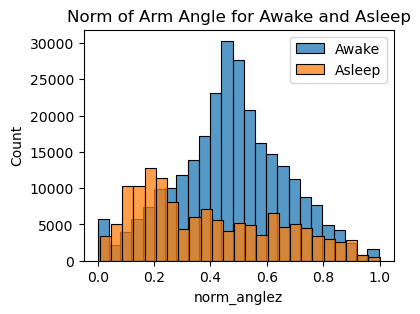

In [15]:
awake_mask = one_person['awake'] == 1
asleep_mask = one_person['awake'] == 0

fig, ax = plt.subplots(figsize=(4,3))

sns.histplot(one_person[awake_mask]['norm_anglez'], label='Awake', bins=25)
sns.histplot(one_person[asleep_mask]['norm_anglez'], label='Asleep', bins=25)

plt.title("Norm of Arm Angle for Awake and Asleep")
plt.legend()
plt.show()

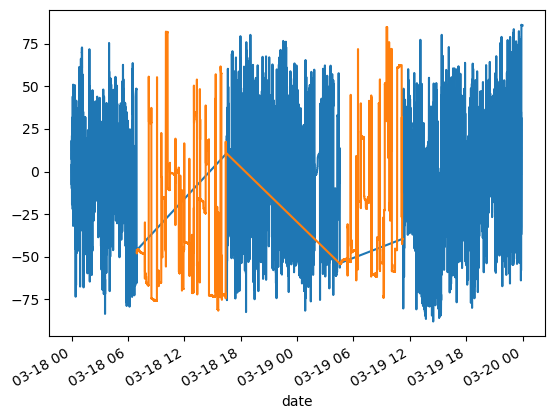

In [16]:
# let's look at a specific slice of time in order to see what's
# happening

start_date = '2018-03-18'
end_date = '2018-03-19'

one_person[awake_mask].loc[start_date : end_date]['anglez'].plot()
one_person[asleep_mask].loc[start_date : end_date]['anglez'].plot()

plt.show()

In [88]:
cols = ['norm_anglez', 'norm_enmo']

one_person[['norm_anglez_diff', 'norm_enmo_diff']] = one_person[cols].diff()
one_person['ewm_enmo_diff_mean'] = one_person['norm_enmo_diff'].ewm(span=100).mean()
one_person['ewm_enmo_diff_std'] = one_person['norm_enmo_diff'].ewm(span=100).std()

one_person['filtered_enmo'] = gaussian_filter(one_person['norm_enmo'], sigma=2)
one_person['filtered_anglez'] = gaussian_filter(one_person['norm_anglez'], sigma=2)

In [89]:
# experimenting with rolling windows and so on
one_person['rolling_enmo_mean'] = one_person['norm_enmo'].rolling(window=101, center=True, min_periods=1).mean()

ewm_window = 100
alpha = 2 / (ewm_window + 1)

standard_ewm = one_person['norm_enmo'].ewm(alpha=alpha, min_periods=1).mean()
reversed_ewm = one_person['norm_enmo'][::-1].ewm(alpha=alpha, min_periods=1).mean()[::-1]

standard_ewm_std = one_person['norm_enmo'].ewm(alpha=alpha, min_periods=1).std()
reversed_ewm_std = one_person['norm_enmo'][::-1].ewm(alpha=alpha, min_periods=1).std()[::-1]

one_person['centered_ewm_enmo_mean'] = (standard_ewm + reversed_ewm) / 2
one_person['centered_ewm_enmo_std'] = (standard_ewm_std + reversed_ewm_std) / 2

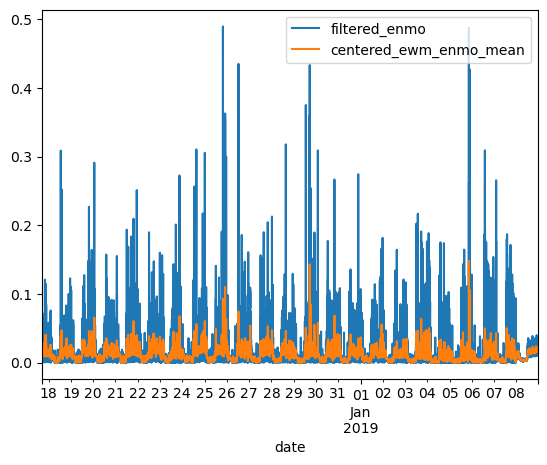

In [127]:
one_person[['filtered_enmo', 'centered_ewm_enmo_mean']].plot()

plt.show()

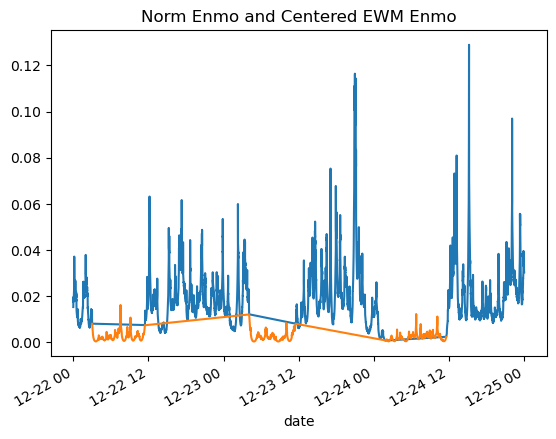

In [129]:
start_date = '2018-12-22'
end_date = '2018-12-24'

# one_person[awake_mask].loc[start_date : end_date]['norm_enmo'].plot()
# one_person[asleep_mask].loc[start_date : end_date]['norm_enmo'].plot()

one_person[awake_mask].loc[start_date : end_date]['centered_ewm_enmo_std'].plot()
one_person[asleep_mask].loc[start_date : end_date]['centered_ewm_enmo_std'].plot()

plt.title("Norm Enmo and Centered EWM Enmo")
plt.show()

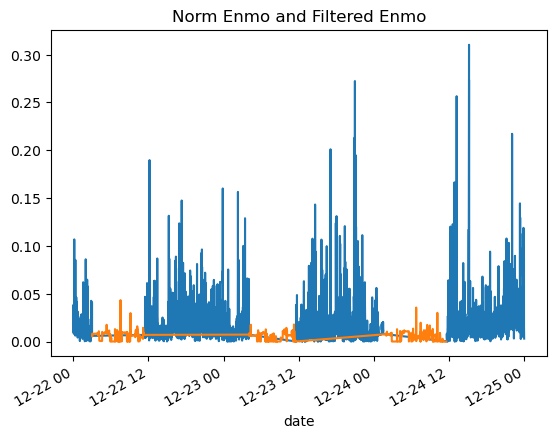

In [125]:
one_person[awake_mask].loc[start_date : end_date]['filtered_enmo'].plot()
one_person[asleep_mask].loc[start_date : end_date]['filtered_enmo'].plot()

plt.title("Norm Enmo and Filtered Enmo")
plt.show()

# Examining sleep transitions

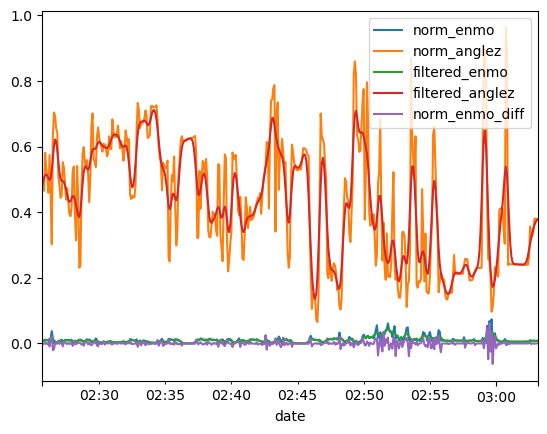

In [89]:
# getting the step range

nights = np.arange(2, 44, 2)

NIGHT = 4

night_mask = one_person['awake_asleep_count'] == nights[NIGHT]

asleep_step = one_person[asleep_mask & night_mask]['step'][0]

begin_step = asleep_step - 425
end_step = asleep_step + 25

sleep_transition = one_person[one_person['step'].between(begin_step, end_step)].copy()

sleep_transition[['norm_enmo', 'norm_anglez', 'C', 'filtered_anglez', 'norm_enmo_diff']].plot()
plt.show()

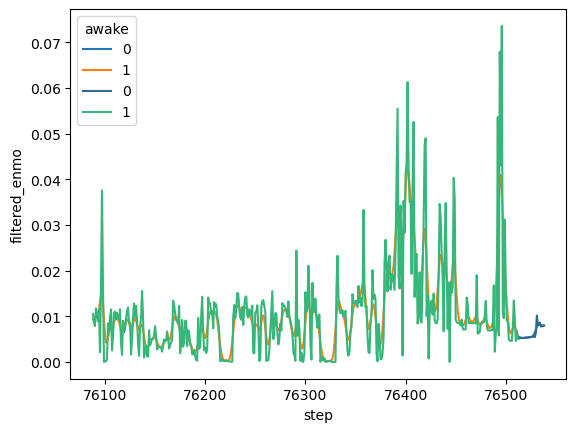

In [105]:
# first_sleep_transition[['ewm_enmo_diff_mean', 'ewm_enmo_diff_std', 'smooth_std']].plot()

sns.lineplot(x='step', y='filtered_enmo', data=sleep_transition, hue='awake')
sns.lineplot(x='step', y='norm_enmo', data=sleep_transition, hue='awake', palette='viridis')

plt.show()

# LSTM Model

In [17]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense

In [18]:
def create_dataset_middle(X, y, time_steps=1):
    Xs, ys = [], []
    offset = time_steps // 2 
    for i in range(len(X) - time_steps + 1):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + offset])
    return np.array(Xs), np.array(ys)

In [ ]:
def create_middle_dataset(X, y, time_steps=5):
    
    Xs = []
    ys = []
    
    offset = time_steps // 2
    
    for i in range(len(X) - time_steps + 1):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(y)
        ys.append(y.iloc[i + offset])
        
    return np.array(Xs), np.array(ys)

In [78]:
features = ['norm_anglez', 'norm_enmo', 'month', 'hour', 'day']
target = 'awake'

X = one_person[features].copy()
y = one_person[target]

X_lstm, y_lstm = create_dataset_middle(X, y, 125)

In [79]:
print(len(X_lstm) == len(y_lstm))

True


In [80]:
len(X_lstm)

X_lstm = X_lstm[:50000].copy()
y_lstm = y_lstm[:50000]

In [81]:
possible_states = 2

model = Sequential()    

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_lstm[0].shape[0], X_lstm[0].shape[1])))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# LSTM Layers
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

In [82]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [83]:
model.fit(X_lstm, y_lstm, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 118s 92ms/step - loss: 0.1764 - accuracy: 0.9354 - val_loss: 0.1302 - val_accuracy: 0.9448
Epoch 2/10
1250/1250 [==============================] - 113s 90ms/step - loss: 0.1091 - accuracy: 0.9563 - val_loss: 0.1617 - val_accuracy: 0.9446
Epoch 3/10
1250/1250 [==============================] - 113s 91ms/step - loss: 0.1129 - accuracy: 0.9549 - val_loss: 0.1076 - val_accuracy: 0.9555
Epoch 4/10
1250/1250 [==============================] - 115s 92ms/step - loss: 0.1190 - accuracy: 0.9565 - val_loss: 0.2606 - val_accuracy: 0.8916
Epoch 5/10
1250/1250 [==============================] - 140s 112ms/step - loss: 0.1341 - accuracy: 0.9521 - val_loss: 0.1241 - val_accuracy: 0.9482
Epoch 6/10
1250/1250 [==============================] - 148s 118ms/step - loss: 0.0991 - accuracy: 0.9559 - val_loss: 0.1475 - val_accuracy: 0.9623
Epoch 7/10
1250/1250 [==============================] - 156s 125ms/step - loss: 0.1115 - accuracy: 0.9551 - val_loss

In [84]:
preds = model.predict(X_lstm)
preds = preds.flatten()

1563/1563 [==============================] - 57s 36ms/step


(50000, 1)

In [86]:
pred_df = pd.DataFrame({'actual' : y_lstm.flatten(), 'preds' : preds})

pred_df['rounded_pred'] = pred_df['smooth_pred'].round()
pred_df['smooth_pred'] = gaussian_filter(pred_df['preds'], sigma=500)

<Axes: >

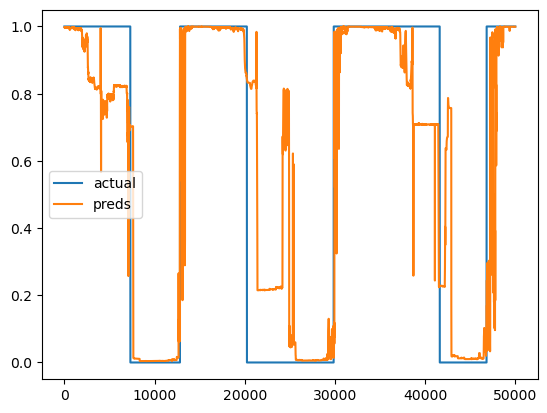

In [87]:
pred_df.plot()

In [90]:
pred_df.to_csv('pred.csv', index=False)

<Axes: >

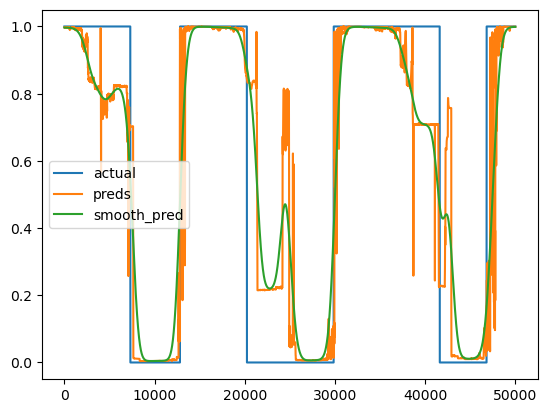

In [97]:
pred_df.plot()

In [ ]:
roc_score = roc_auc_score(pred_df['actual'], pred_df['preds'])

# 
conf_matrix = confusion_matrix(pred_df['actual'], pred_df['rounded_pred'])
cm_display = ConfusionMatrixDisplay(conf_matrix).plot(cmap='viridis')

plt.show()

In [103]:
class ParticipantVisibleError(Exception):
    pass


    # Set some placeholders for global parameters
    series_id_column_name = None
    time_column_name = None
    event_column_name = None
    score_column_name = None
    use_scoring_intervals = None


    def score(
            solution: pd.DataFrame,
            submission: pd.DataFrame,
            tolerances: dict[str, list[float]],
            series_id_column_name: str,
            time_column_name: str,
            event_column_name: str,
            score_column_name: str,
            use_scoring_intervals: bool = False,
    ) -> float:
        """Event Detection Average Precision, an AUCPR metric for event detection in
        time series and video.

        This metric is similar to IOU-threshold average precision metrics commonly
        used in object detection. For events occuring in time series, we replace the
        IOU threshold with a time tolerance.

        Submissions are evaluated on the average precision of detected events,
        averaged over timestamp error tolerance thresholds, averaged over event
        classes.

        Detections are matched to ground-truth events within error tolerances, with
        ambiguities resolved in order of decreasing confidence.

        Detailed Description
        --------------------
        Evaluation proceeds in four steps:

        1. Selection - (optional) Predictions not within a series' scoring
        intervals are dropped.
        2. Assignment - Predicted events are matched with ground-truth events.
        3. Scoring - Each group of predictions is scored against its corresponding
        group of ground-truth events via Average Precision.
        4. Reduction - The multiple AP scores are averaged to produce a single
        overall score.

        Selection

        With each series there may be a defined set of scoring intervals giving the
        intervals of time over which zero or more ground-truth events might be
        annotated in that series. A prediction will be evaluated only if it falls
        within a scoring interval. These scoring intervals can be chosen to improve
        the fairness of evaluation by, for instance, ignoring edge-cases or
        ambiguous events.

        It is recommended that, if used, scoring intervals be provided for training
        data but not test data.

        Assignment

        For each set of predictions and ground-truths within the same `event x
        tolerance x series_id` group, we match each ground-truth to the
        highest-confidence unmatched prediction occurring within the allowed
        tolerance.

        Some ground-truths may not be matched to a prediction and some predictions
        may not be matched to a ground-truth. They will still be accounted for in
        the scoring, however.

        Scoring

        Collecting the events within each `series_id`, we compute an Average
        Precision score for each `event x tolerance` group. The average precision
        score is the area under the (step-wise) precision-recall curve generated by
        decreasing confidence score thresholds over the predictions. In this
        calculation, matched predictions over the threshold are scored as TP and
        unmatched predictions as FP. Unmatched ground-truths are scored as FN.

        Reduction

        The final score is the average of the above AP scores, first averaged over
        tolerance, then over event.

        Parameters
        ----------
        solution : pd.DataFrame, with columns:

            `series_id_column_name` identifier for each time series

            `time_column_name` the time of occurence for each event as a numeric type

            `event_column_name` class label for each event

            The solution contains the time of occurence of one or more types of
            event within one or more time series. The metric expects the solution to
            contain the same event types as those given in `tolerances`.

            When `use_scoring_intervals == True`, you may include `start` and `end`
            events to delimit intervals within which detections will be scored.
            Detected events (from the user submission) outside of these events will
            be ignored.

        submission : pd.DataFrame, with columns as above and in addition:

            `score_column_name` the predicted confidence score for the detected event

        tolerances : Dict[str, List[float]]

            Maps each event class to a list of timestamp tolerances used
            for matching detections to ground-truth events.

        use_scoring_intervals: bool, default False

            Whether to ignore predicted events outside intervals delimited
            by `'start'` and `'end'` events in the solution. When `False`,
            the solution should not include `'start'` and `'end'` events.
            See the examples for illustration.

        Returns
        -------
        event_detection_ap : float
            The mean average precision of the detected events.

        Examples
        --------
        Detecting `'pass'` events in football:
        >>> column_names = {
        ...     'series_id_column_name': 'video_id',
        ...     'time_column_name': 'time',
        ...     'event_column_name': 'event',
        ...     'score_column_name': 'score',
        ... }
        >>> tolerances = {'pass': [1.0]}
        >>> solution = pd.DataFrame({
        ...     'video_id': ['a', 'a'],
        ...     'event': ['pass', 'pass'],
        ...     'time': [0, 15],
        ... })
        >>> submission = pd.DataFrame({
        ...     'video_id': ['a', 'a', 'a'],
        ...     'event': ['pass', 'pass', 'pass'],
        ...     'score': [1.0, 0.5, 1.0],
        ...     'time': [0, 10, 14.5],
        ... })
        >>> score(solution, submission, tolerances, **column_names)
        1.0

        Increasing the confidence score of the false detection above the true
        detections decreases the AP.
        >>> submission.loc[1, 'score'] = 1.5
        >>> score(solution, submission, tolerances, **column_names)
        0.6666666666666666...

        Likewise, decreasing the confidence score of a true detection below the
        false detection also decreases the AP.
        >>> submission.loc[1, 'score'] = 0.5  # reset
        >>> submission.loc[0, 'score'] = 0.0
        >>> score(solution, submission, tolerances, **column_names)
        0.8333333333333333...

        We average AP scores over tolerances. Previously, the detection at 14.5
        would match, but adding smaller tolerances gives AP scores where it does
        not match. This results in both a FN, since the ground-truth wasn't
        detected, and a FP, since the detected event matches no ground-truth.
        >>> tolerances = {'pass': [0.1, 0.2, 1.0]}
        >>> score(solution, submission, tolerances, **column_names)
        0.3888888888888888...

        We also average over time series and over event classes.
        >>> tolerances = {'pass': [0.5, 1.0], 'challenge': [0.25, 0.50]}
        >>> solution = pd.DataFrame({
        ...     'video_id': ['a', 'a', 'b'],
        ...     'event': ['pass', 'challenge', 'pass'],
        ...     'time': [0, 15, 0],  # restart time for new time series b
        ... })
        >>> submission = pd.DataFrame({
        ...     'video_id': ['a', 'a', 'b'],
        ...     'event': ['pass', 'challenge', 'pass'],
        ...     'score': [1.0, 0.5, 1.0],
        ...     'time': [0, 15, 0],
        ... })
        >>> score(solution, submission, tolerances, **column_names)
        1.0

        By adding scoring intervals to the solution, we may choose to ignore
        detections outside of those intervals.
        >>> tolerances = {'pass': [1.0]}
        >>> solution = pd.DataFrame({
        ...     'video_id': ['a', 'a', 'a', 'a'],
        ...     'event': ['start', 'pass', 'pass', 'end'],
        ...     'time': [0, 10, 20, 30],
        ... })
        >>> submission = pd.DataFrame({
        ...     'video_id': ['a', 'a', 'a'],
        ...     'event': ['pass', 'pass', 'pass'],
        ...     'score': [1.0, 1.0, 1.0],
        ...     'time': [10, 20, 40],
        ... })
        >>> score(solution, submission, tolerances, **column_names, use_scoring_intervals=True)
        1.0

        """
        # Validate metric parameters
        assert len(tolerances) > 0, "Events must have defined tolerances."
        assert set(tolerances.keys()) == set(solution[event_column_name]).difference({'start', 'end'}),\
            (f"Solution column {event_column_name} must contain the same events "
             "as defined in tolerances.")
        assert pd.api.types.is_numeric_dtype(solution[time_column_name]),\
            f"Solution column {time_column_name} must be of numeric type."

        # Validate submission format
        for column_name in [
            series_id_column_name,
            time_column_name,
            event_column_name,
            score_column_name,
        ]:
            if column_name not in submission.columns:
                raise ParticipantVisibleError(f"Submission must have column '{target_name}'.")

        if not pd.api.types.is_numeric_dtype(submission[time_column_name]):
            raise ParticipantVisibleError(
                f"Submission column '{time_column_name}' must be of numeric type."
            )
        if not pd.api.types.is_numeric_dtype(submission[score_column_name]):
            raise ParticipantVisibleError(
                f"Submission column '{score_column_name}' must be of numeric type."
            )

        # Set these globally to avoid passing around a bunch of arguments
        globals()['series_id_column_name'] = series_id_column_name
        globals()['time_column_name'] = time_column_name
        globals()['event_column_name'] = event_column_name
        globals()['score_column_name'] = score_column_name
        globals()['use_scoring_intervals'] = use_scoring_intervals

        return event_detection_ap(solution, submission, tolerances)


    def filter_detections(
            detections: pd.DataFrame, intervals: pd.DataFrame
    ) -> pd.DataFrame:
        """Drop detections not inside a scoring interval."""
        detection_time = detections.loc[:, time_column_name].sort_values().to_numpy()
        intervals = intervals.to_numpy()
        is_scored = np.full_like(detection_time, False, dtype=bool)

        i, j = 0, 0
        while i < len(detection_time) and j < len(intervals):
            time = detection_time[i]
            int_ = intervals[j]

            # If the detection is prior in time to the interval, go to the next detection.
            if time < int_.left:
                i += 1
            # If the detection is inside the interval, keep it and go to the next detection.
            elif time in int_:
                is_scored[i] = True
                i += 1
            # If the detection is later in time, go to the next interval.
            else:
                j += 1

        return detections.loc[is_scored].reset_index(drop=True)


    def match_detections(
            tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
    ) -> pd.DataFrame:
        """Match detections to ground truth events. Arguments are taken from a common event x tolerance x series_id evaluation group."""
        detections_sorted = detections.sort_values(score_column_name, ascending=False).dropna()
        is_matched = np.full_like(detections_sorted[event_column_name], False, dtype=bool)
        gts_matched = set()
        for i, det in enumerate(detections_sorted.itertuples(index=False)):
            best_error = tolerance
            best_gt = None

            for gt in ground_truths.itertuples(index=False):
                error = abs(getattr(det, time_column_name) - getattr(gt, time_column_name))
                if error < best_error and gt not in gts_matched:
                    best_gt = gt
                    best_error = error

            if best_gt is not None:
                is_matched[i] = True
                gts_matched.add(best_gt)

        detections_sorted['matched'] = is_matched

        return detections_sorted


    def precision_recall_curve(
            matches: np.ndarray, scores: np.ndarray, p: int
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        if len(matches) == 0:
            return [1], [0], []

        # Sort matches by decreasing confidence
        idxs = np.argsort(scores, kind='stable')[::-1]
        scores = scores[idxs]
        matches = matches[idxs]

        distinct_value_indices = np.where(np.diff(scores))[0]
        threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
        thresholds = scores[threshold_idxs]

        # Matches become TPs and non-matches FPs as confidence threshold decreases
        tps = np.cumsum(matches)[threshold_idxs]
        fps = np.cumsum(~matches)[threshold_idxs]

        precision = tps / (tps + fps)
        precision[np.isnan(precision)] = 0
        recall = tps / p  # total number of ground truths might be different than total number of matches

        # Stop when full recall attained and reverse the outputs so recall is non-increasing.
        last_ind = tps.searchsorted(tps[-1])
        sl = slice(last_ind, None, -1)

        # Final precision is 1 and final recall is 0
        return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


    def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
        precision, recall, _ = precision_recall_curve(matches, scores, p)
        # Compute step integral
        return -np.sum(np.diff(recall) * np.array(precision)[:-1])


    def event_detection_ap(
            solution: pd.DataFrame,
            submission: pd.DataFrame,
            tolerances: dict[str, list[float]],
    ) -> float:

        # Ensure solution and submission are sorted properly
        solution = solution.sort_values([series_id_column_name, time_column_name])
        submission = submission.sort_values([series_id_column_name, time_column_name])

        # Extract scoring intervals.
        if use_scoring_intervals:
            intervals = (
                solution
                .query("event in ['start', 'end']")
                .assign(interval=lambda x: x.groupby([series_id_column_name, event_column_name]).cumcount())
                .pivot(
                    index='interval',
                    columns=[series_id_column_name, event_column_name],
                    values=time_column_name,
                )
                .stack(series_id_column_name)
                .swaplevel()
                .sort_index()
                .loc[:, ['start', 'end']]
                .apply(lambda x: pd.Interval(*x, closed='both'), axis=1)
            )

        # Extract ground-truth events.
        ground_truths = (
            solution
            .query("event not in ['start', 'end']")
            .reset_index(drop=True)
        )

        # Map each event class to its prevalence (needed for recall calculation)
        class_counts = ground_truths.value_counts(event_column_name).to_dict()

        # Create table for detections with a column indicating a match to a ground-truth event
        detections = submission.assign(matched = False)

        # Remove detections outside of scoring intervals
        if use_scoring_intervals:
            detections_filtered = []
            for (det_group, dets), (int_group, ints) in zip(
                detections.groupby(series_id_column_name), intervals.groupby(series_id_column_name)
            ):
                assert det_group == int_group
                detections_filtered.append(filter_detections(dets, ints))
            detections_filtered = pd.concat(detections_filtered, ignore_index=True)
        else:
            detections_filtered = detections

        # Create table of event-class x tolerance x series_id values
        aggregation_keys = pd.DataFrame(
            [(ev, tol, vid)
             for ev in tolerances.keys()
             for tol in tolerances[ev]
             for vid in ground_truths[series_id_column_name].unique()],
            columns=[event_column_name, 'tolerance', series_id_column_name],
        )

        # Create match evaluation groups: event-class x tolerance x series_id
        detections_grouped = (
            aggregation_keys
            .merge(detections_filtered, on=[event_column_name, series_id_column_name], how='left')
            .groupby([event_column_name, 'tolerance', series_id_column_name])
        )
        ground_truths_grouped = (
            aggregation_keys
            .merge(ground_truths, on=[event_column_name, series_id_column_name], how='left')
            .groupby([event_column_name, 'tolerance', series_id_column_name])
        )
        # Match detections to ground truth events by evaluation group
        detections_matched = []
        for key in aggregation_keys.itertuples(index=False):
            dets = detections_grouped.get_group(key)
            gts = ground_truths_grouped.get_group(key)
            detections_matched.append(
                match_detections(dets['tolerance'].iloc[0], gts, dets)
            )
        detections_matched = pd.concat(detections_matched)

        # Compute AP per event x tolerance group
        event_classes = ground_truths[event_column_name].unique()
        ap_table = (
            detections_matched
            .query("event in @event_classes")
            .groupby([event_column_name, 'tolerance']).apply(
                lambda group: average_precision_score(
                    group['matched'].to_numpy(),
                    group[score_column_name].to_numpy(),
                    class_counts[group[event_column_name].iat[0]],
                )
            )
        )
        # Average over tolerances, then over event classes
        mean_ap = ap_table.groupby(event_column_name).mean().sum() / len(event_classes)

        return mean_ap

In [104]:
tolerances = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]